# Zee Recommender Systems

### Problem Statement

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

### Data Description

RATINGS FILE DESCRIPTION

=========================================================================

All ratings are contained in the file "ratings.dat" and are in the following format:

UserID::MovieID::Rating::Timestamp

UserIDs range between 1 and 6040

MovieIDs range between 1 and 3952

Ratings are made on a 5-star scale (whole-star ratings only)

Timestamp is represented in seconds

Each user has at least 20 ratings

USERS FILE DESCRIPTION

=========================================================================

User information is in the file "users.dat" and is in the following format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is not checked for accuracy.
Only users who have provided some demographic information are included in this data set.

Gender is denoted by a "M" for male and "F" for female

Age is chosen from the following ranges:

1: "Under 18"

18: "18-24"

25: "25-34"

35: "35-44"

45: "45-49"

50: "50-55"

56: "56+"

Occupation is chosen from the following choices:

0: "other" or not specified

1: "academic/educator"

2: "artist"

3: "clerical/admin"

4: "college/grad student"

5: "customer service"

6: "doctor/health care"

7: "executive/managerial"

8: "farmer"

9: "homemaker"

10: "K-12 student"

11: "lawyer"

12: "programmer"

13: "retired"

14: "sales/marketing"

15: "scientist"

16: "self-employed"

17: "technician/engineer"

18: "tradesman/craftsman"

19: "unemployed"

20: "writer"

MOVIES FILE DESCRIPTION

=========================================================================

Movie information is in the file "movies.dat" and is in the following format:

MovieID::Title::Genres

Titles are identical to titles provided by the IMDB (including year of release)

Genres are pipe-separated and are selected from the following genres:

Action

Adventure

Animation

Children's

Comedy

Crime

Documentary

Drama

Fantasy

Film-Noir

Horror

Musical

Mystery

Romance

Sci-Fi

Thriller

War

Western

Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [2]:
!gdown 1kzl-zKw26vmckFm1V3cWJ7G2JgaxBDE4

Downloading...
From: https://drive.google.com/uc?id=1kzl-zKw26vmckFm1V3cWJ7G2JgaxBDE4
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 52.8MB/s]


In [3]:
!gdown 1avRgScAGuZI_-LVBvQAAuGcsSRb2jcYb

Downloading...
From: https://drive.google.com/uc?id=1avRgScAGuZI_-LVBvQAAuGcsSRb2jcYb
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 44.8MB/s]


In [4]:
!gdown 145MkHf4hY7_l8B2KAxjxQEqC3mHsVjxZ

Downloading...
From: https://drive.google.com/uc?id=145MkHf4hY7_l8B2KAxjxQEqC3mHsVjxZ
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 77.1MB/s]


#### Dataset

In [14]:
movies_df = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
ratings_df = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
users_df = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [7]:
movies_df.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [6]:
ratings_df.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [8]:
users_df.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


#### Data Preprocessing

In [15]:
delimiter ="::"
movies_df = movies_df["Movie ID::Title::Genres"].str.split(delimiter,expand = True)
movies_df.columns = ["MovieID","Title","Genres"]

movies_df["Release_year"] = movies_df["Title"].str.extract('^(.+)\s\(([0-9]*)\)$',expand = True)[1]
movies_df["Title"] = movies_df["Title"].str.split("(").apply(lambda x:x[0])

In [16]:
movies_df.head()

,MovieID,Title,Genres,Release_year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [17]:
from datetime import datetime

delimiter = "::"
ratings_df = ratings_df["UserID::MovieID::Rating::Timestamp"].str.split(delimiter,expand = True)
ratings_df.columns = ["UserID","MovieID","Rating","Timestamp"]
ratings_df["Watch_Hour"] =ratings_df["Timestamp"].apply(lambda x:datetime.fromtimestamp(int(x)).hour)
ratings_df.drop(["Timestamp"],axis = 1,inplace=True)

In [18]:
ratings_df.head()

,UserID,MovieID,Rating,Watch_Hour
0,1,1193,5,22
1,1,661,3,22
2,1,914,3,22
3,1,3408,4,22
4,1,2355,5,23


In [19]:
users_df = users_df["UserID::Gender::Age::Occupation::Zip-code"].str.split(delimiter,expand = True)
users_df.columns = ["UserID","Gender","Age","Occupation","Zip-code"]
#Binnig the ages
users_df["Age"].replace({"1": "Under 18","18": "18-24","25": "25-34","35": "35-44","45": "45-49","50": "50-55","56": "56+"},inplace=True)
#Replacing the Occupation id with Name as per the information given
users_df["Occupation"] = users_df["Occupation"].astype(int).replace({0: "other",1: "academic/educator",2: "artist",3: "clerical/admin",4: "college/grad student",5: "customer service",
                                                                     6: "doctor/health care",7: "executive/managerial",8: "farmer" ,9: "homemaker",10: "K-12 student",11: "lawyer",
                                                                     12: "programmer",13: "retired",14: "sales/marketing",15: "scientist",16: "self-employed",17: "technician/engineer",
                                                                     18: "tradesman/craftsman",19: "unemployed",20: "writer"},)

In [20]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,K-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


In [23]:
dfmov = movies_df.copy()
dfmov.dropna(inplace=True)
dfmov.Genres = dfmov.Genres.str.split('|')
dfmov['Genres'] = dfmov['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])
for i in dfmov['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'
dfmov.head()

,MovieID,Title,Genres,Release_year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Merging the above datasets to single format

In [24]:
dfmov.shape,ratings_df.shape,users_df.shape

((3857, 4), (1000209, 4), (6040, 5))

In [25]:
df = users_df.merge(dfmov.merge(ratings_df,on="MovieID",how="inner"),on="UserID",how="inner")

In [26]:
df.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Title,Genres,Release_year,Rating,Watch_Hour
0,1,F,Under 18,K-12 student,48067,1,Toy Story,"[Animation, Children's, Comedy]",1995,5,23
1,1,F,Under 18,K-12 student,48067,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,5,23
2,1,F,Under 18,K-12 student,48067,150,Apollo 13,[Drama],1995,5,22
3,1,F,Under 18,K-12 student,48067,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1977,4,22
4,1,F,Under 18,K-12 student,48067,527,Schindler's List,"[Drama, War]",1993,5,23


In [27]:
df.shape

(996144, 11)

In [28]:
df.UserID = df.UserID.astype(float)
df.Rating = df.Rating.astype(float)
df.Release_year = df.Release_year.astype(float)
# Converting the release years to numbers
df['Release_year']=df['Release_year'].astype('int32')
df['Rating']=df['Rating'].astype('int32')

#### Missing Values Check

In [29]:
missing_value = pd.DataFrame({
    'Missing Value': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df))*100
})

In [30]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
UserID,0,0.0
Gender,0,0.0
Age,0,0.0
Occupation,0,0.0
Zip-code,0,0.0
MovieID,0,0.0
Title,0,0.0
Genres,0,0.0
Release_year,0,0.0
Rating,0,0.0


We have no missing values

In [31]:
d = df.copy()

In [32]:
d.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Title,Genres,Release_year,Rating,Watch_Hour
0,1.0,F,Under 18,K-12 student,48067,1,Toy Story,"[Animation, Children's, Comedy]",1995,5,23
1,1.0,F,Under 18,K-12 student,48067,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,5,23
2,1.0,F,Under 18,K-12 student,48067,150,Apollo 13,[Drama],1995,5,22
3,1.0,F,Under 18,K-12 student,48067,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1977,4,22
4,1.0,F,Under 18,K-12 student,48067,527,Schindler's List,"[Drama, War]",1993,5,23


In [33]:
d['Release_year'].unique()

array([1995, 1977, 1993, 1992, 1937, 1991, 1996, 1964, 1939, 1958, 1950,
       1941, 1965, 1982, 1975, 1987, 1962, 1989, 1985, 1959, 1997, 1998,
       1988, 1942, 1947, 1999, 1980, 1983, 1986, 1990, 2000, 1994, 1961,
       1955, 1967, 1981, 1984, 1979, 1951, 1954, 1971, 1976, 1960, 1940,
       1948, 1973, 1974, 1969, 1972, 1978, 1966, 1933, 1968, 1957, 1952,
       1953, 1944, 1946, 1949, 1963, 1970, 1930, 1956, 1920, 1925, 1945,
       1926, 1938, 1935, 1932, 1931, 1943, 1934, 1936, 1927, 1922, 1929,
       1919, 1921, 1923, 1928], dtype=int32)

In [34]:
#Binnig the years
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']

d['Decade'] = pd.cut(d['Release_year'], bins=bins, labels=labels)

In [35]:
d.head()

,UserID,Gender,Age,Occupation,Zip-code,MovieID,Title,Genres,Release_year,Rating,Watch_Hour,Decade
0,1.0,F,Under 18,K-12 student,48067,1,Toy Story,"[Animation, Children's, Comedy]",1995,5,23,90s
1,1.0,F,Under 18,K-12 student,48067,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,5,23,90s
2,1.0,F,Under 18,K-12 student,48067,150,Apollo 13,[Drama],1995,5,22,90s
3,1.0,F,Under 18,K-12 student,48067,260,Star Wars: Episode IV - A New Hope,"[Action, Adventure, Fantasy]",1977,4,22,70s
4,1.0,F,Under 18,K-12 student,48067,527,Schindler's List,"[Drama, War]",1993,5,23,90s


### Movies Per Decade

In [36]:
movies_per_decade = d[['MovieID','Decade']].groupby('Decade').nunique()
movies_per_decade["% of movies per decade"] = (movies_per_decade["MovieID"]/(d["MovieID"].nunique()))*100
movies_per_decade

,MovieID,% of movies per decade
Decade,,
20s,23,0.624661
30s,71,1.928300
40s,120,3.259098
50s,164,4.454101
60s,184,4.997284
70s,237,6.436719
80s,586,15.915263
90s,2294,62.303096


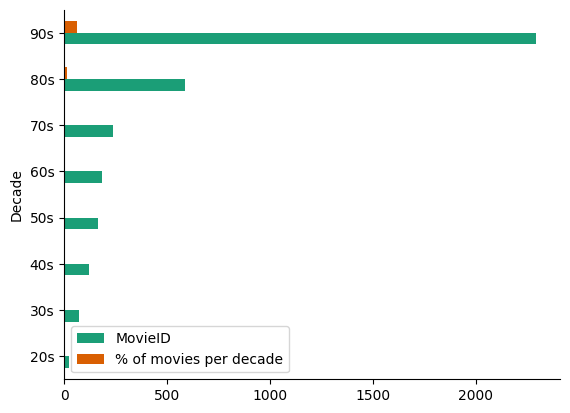

In [37]:
movies_per_decade.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Data Visualization

### Watch Hour

In [39]:
d['Watch_Hour'].value_counts().sort_values(ascending=False)

,count
Watch_Hour,
21,65215
3,62148
20,59460
19,58948
18,58883
2,58818
1,57994
4,55215
0,55193


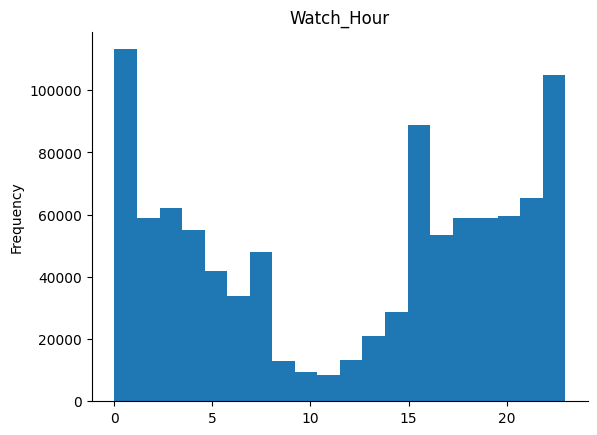

In [40]:
d['Watch_Hour'].plot(kind='hist', bins=20, title='Watch_Hour')
plt.gca().spines[['top', 'right',]].set_visible(False)

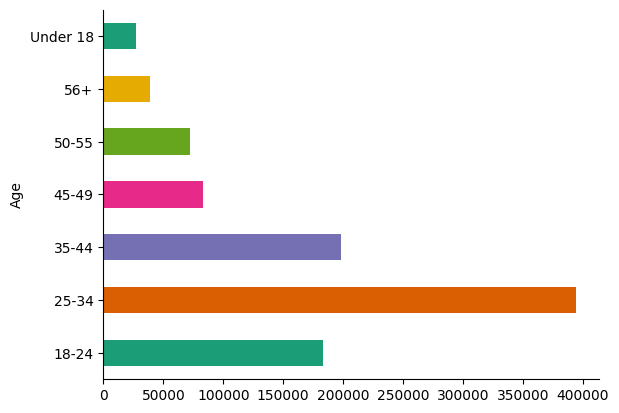

In [41]:
d.groupby('Age').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Average Rating

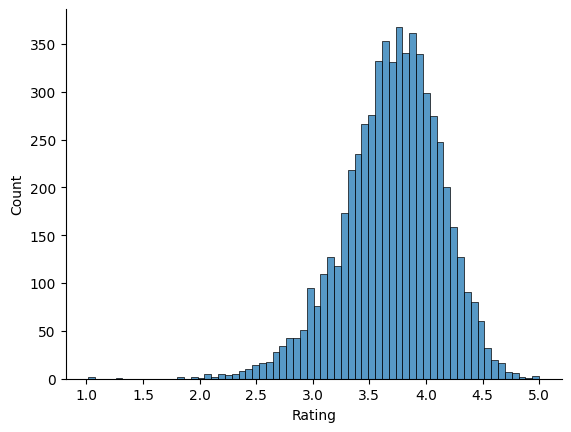

In [44]:
sns.histplot(d[['UserID','Rating']].groupby('UserID').mean()['Rating'])
plt.gca().spines[['top', 'right',]].set_visible(False)

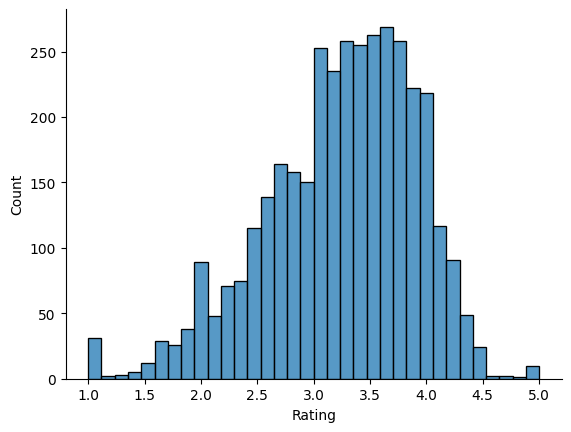

In [42]:
sns.histplot(d[['MovieID','Rating']].groupby('MovieID').mean()['Rating'])
plt.gca().spines[['top', 'right',]].set_visible(False)

### Release Year

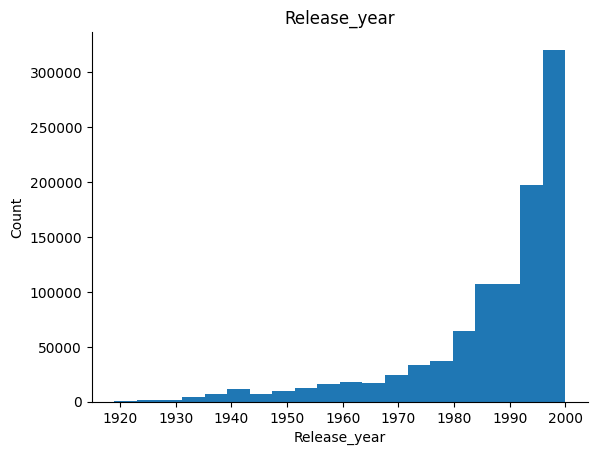

In [ ]:
d['Release_year'].plot(kind='hist', bins=20, title='Release_year')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel('Release_year')
plt.ylabel('Count')
plt.show()

### Movies per Genre

In [50]:
dfmov.head()

,MovieID,Title,Genres,Release_year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [52]:
genres_df = pd.get_dummies(dfmov['Genres'].apply(pd.Series).stack()).groupby(level=0).sum()
genres_df.head()

,,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
### considering only the genre columns for the genre
genres = genres_df.iloc[:,0:].sum()
genres=genres.iloc[1:]
print(genres)

Action          501
Adventure       282
Animation       104
Children's      249
Comedy         1188
Crime           210
Documentary     124
Drama          1582
Fantasy          62
Film-Noir        44
Horror          340
Musical         113
Mystery         105
Romance         462
Sci-Fi          265
Thriller        488
War             139
Western          68
dtype: int64


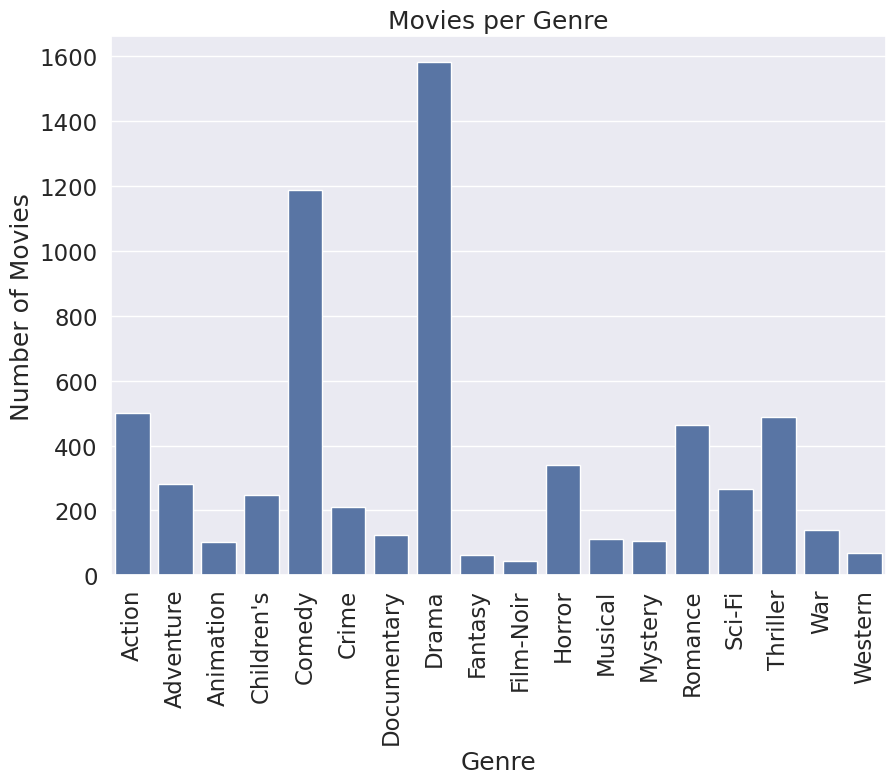

In [56]:
plt.figure(figsize=(10, 7))
sns.barplot(x=genres.index, y=genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movies per Genre')
sns.set(font_scale=1.5)
plt.show()

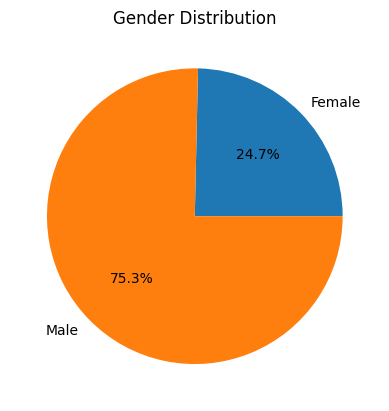

In [47]:
gr = d.groupby("Gender")["Rating"].count() / d["Rating"].count() * 100
plt.pie(gr,labels = ["Female","Male"],autopct='%1.1f%%')
plt.title("Gender Distribution")
plt.show()

#### User Occupation Distribution

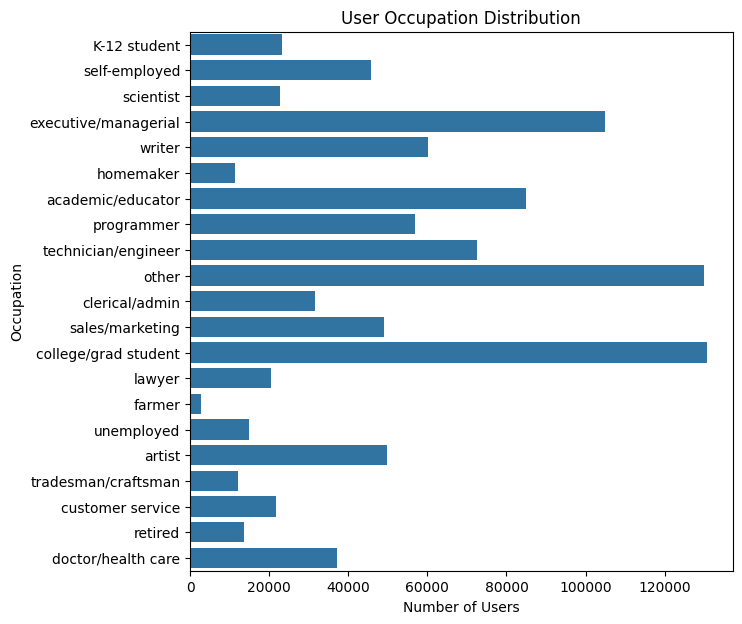

In [48]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=d)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

###Top 10 Movies by Rating

In [49]:
top10_movies = d.groupby("Title")["Rating"].count().reset_index().sort_values(by="Rating",ascending=False).head(10)
top10_movies

,Title,Rating
125,American Beauty,3428
3092,Star Wars: Episode IV - A New Hope,2991
3093,Star Wars: Episode V - The Empire Strikes Back,2990
3094,Star Wars: Episode VI - Return of the Jedi,2883
1756,Jurassic Park,2672
2837,Saving Private Ryan,2653
3231,Terminator 2: Judgment Day,2649
2070,"Matrix, The",2590
255,Back to the Future,2583
2929,"Silence of the Lambs, The",2578


In [57]:
#Grouping the data in terms of Average Rating and No. of Ratings given

df_rating = d.groupby('Title').agg({'Rating': ['mean', 'count']})
df_rating.columns = ['avg_rating', 'num_ratings']
df_rating.reset_index(inplace=True)
df_rating.sort_values(by=['avg_rating','num_ratings'],ascending=False,inplace=True)

df_rating.head(10)

,Title,avg_rating,num_ratings
1276,"Gate of Heavenly Peace, The",5.0,3
2983,Smashing Time,5.0,2
246,"Baby, The",5.0,1
402,Bittersweet Motel,5.0,1
1183,Follow the Bitch,5.0,1
1985,Lured,5.0,1
2403,One Little Indian,5.0,1
2845,Schlafes Bruder,5.0,1
3026,Song of Freedom,5.0,1
3409,Ulysses,5.0,1


#### Pivot Table

User - Interaction Matrix

In [58]:
mat = pd.pivot_table(df, index='UserID', columns='Title', values='Rating', aggfunc='mean')

In [59]:
mat.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin,Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
mat.fillna(0, inplace=True)

In [61]:
mat.shape

(6040, 3633)

In [63]:
# Checking data sparsity
n_users = df['UserID'].nunique()
n_movies = df['MovieID'].nunique()
sparsity = round(1.0 - df.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


## Item Based Approach

### Simple Recommender System using Pearson Correlation

In [65]:
#Use the Item-based approach to create a simple recommender system that uses Pearson Correlation

movie_name = 'Home Alone '
movie_rating = mat[movie_name]

In [66]:
similar_movies = mat.corrwith(movie_rating)

In [67]:
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)

In [68]:
sim_df.iloc[1: , :].head()

,Correlation
Title,
Home Alone 2: Lost in New York,0.547203
Mrs. Doubtfire,0.468281
Liar Liar,0.455967
"Mighty Ducks, The",0.446273
Sister Act,0.444612


In [69]:
#Simple Recommender Fucntion
def recommend(movie_name):
    movie_rating = mat[movie_name]
    similar_movies = mat.corrwith(movie_rating)
    sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
    sim_df.sort_values('Correlation', ascending=False, inplace=True)
    return sim_df.iloc[1: , :].head()

In [70]:
recommend("Young Poisoner's Handbook, The ")

,Correlation
Title,
I Shot Andy Warhol,0.227081
Drugstore Cowboy,0.212546
Hard 8,0.198824
Jupiter's Wife,0.197269
Kids,0.196996


#### Item - Item Similarity

In [71]:
item_similarity = cosine_similarity(mat.T)
item_similarity

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [72]:
item_similarity_mat = pd.DataFrame(item_similarity, index=mat.columns, columns=mat.columns)
item_similarity_mat.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin,Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


#### User - User Similarity

In [73]:
user_sim = cosine_similarity(mat)
user_sim

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17683395,
        0.13476531],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.07366603,
        0.22019558],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09588437,
        0.13431517],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16377988,
        0.10017352],
       [0.17683395, 0.07366603, 0.09588437, ..., 0.16377988, 1.        ,
        0.22489151],
       [0.13476531, 0.22019558, 0.13431517, ..., 0.10017352, 0.22489151,
        1.        ]])

In [74]:
user_sim_mat = pd.DataFrame(user_sim, index=mat.index, columns=mat.index)
user_sim_mat.head()

UserID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
UserID,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.096382,0.120610,0.132455,0.090158,0.181240,0.059678,0.138241,0.226148,0.255319,...,0.170588,0.082006,0.090961,0.033663,0.115121,0.188004,0.137094,0.000000,0.176834,0.134765
2.0,0.096382,1.000000,0.151479,0.171176,0.114394,0.102000,0.305787,0.211120,0.190198,0.228266,...,0.112503,0.091222,0.268565,0.014286,0.183773,0.230294,0.207965,0.066118,0.073666,0.220196
3.0,0.120610,0.151479,1.000000,0.151227,0.062907,0.075443,0.138332,0.077656,0.126457,0.214978,...,0.092960,0.125864,0.161507,0.000000,0.097514,0.144553,0.108627,0.120234,0.095884,0.134315
4.0,0.132455,0.171176,0.151227,1.000000,0.045094,0.013681,0.130339,0.100856,0.093651,0.121485,...,0.163629,0.093041,0.382803,0.000000,0.082271,0.172117,0.128509,0.062907,0.065460,0.139181
5.0,0.090158,0.114394,0.062907,0.045094,1.000000,0.047983,0.126257,0.220817,0.261330,0.117777,...,0.100652,0.035732,0.065278,0.054151,0.179462,0.296003,0.174103,0.020459,0.028042,0.243560


### Simple Recommender System Using Cosine Similarity

In [75]:
csr_mat = sparse.csr_matrix(mat.T.values)
csr_mat

<3633x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 992816 stored elements in Compressed Sparse Row format>

In [76]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [78]:
movie_name = "Jupiter's Wife "
movie_index = mat.columns.get_loc(movie_name)

In [79]:
distances, indices = knn.kneighbors(mat[movie_name].values.reshape(1, -1), n_neighbors = 11)

In [80]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for the movie: {0}\n'.format(movie_name))
    else:
        print('{0}: {1}, with distance of {2}'.format(i, mat.columns[indices.flatten()[i]], round(distances.flatten()[i], 3)))

Recommendations for the movie: Jupiter's Wife 

1: Regret to Inform , with distance of 0.677
2: Home Page , with distance of 0.737
3: On the Ropes , with distance of 0.758
4: American Dream , with distance of 0.774
5: Babyfever , with distance of 0.797
6: Young Poisoner's Handbook, The , with distance of 0.799
7: Dreaming of Joseph Lees , with distance of 0.802
8: Last Klezmer: Leopold Kozlowski, His Life and Music, The , with distance of 0.803
9: And the Ship Sails On , with distance of 0.81
10: Nico Icon , with distance of 0.816


### Matrix Factorization

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996144 entries, 0 to 996143
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   UserID        996144 non-null  float64
 1   Gender        996144 non-null  object 
 2   Age           996144 non-null  object 
 3   Occupation    996144 non-null  object 
 4   Zip-code      996144 non-null  object 
 5   MovieID       996144 non-null  object 
 6   Title         996144 non-null  object 
 7   Genres        996144 non-null  object 
 8   Release_year  996144 non-null  int32  
 9   Rating        996144 non-null  int32  
 10  Watch_Hour    996144 non-null  int64  
dtypes: float64(1), int32(2), int64(1), object(7)
memory usage: 76.0+ MB


In [82]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create utility matrices
train_matrix = train_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
val_matrix = val_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

In [87]:
user_itm = d[['UserID', 'MovieID', 'Rating']].copy()
user_itm.columns = ['UserId', 'ItemId', 'Rating']

In [92]:
r_itm = d.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)

In [89]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 5.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post10-cp310-cp310-linux_x86_64.whl size=5669609 sha256=ae60874060f6c75fe24751b7339d410a05bd5e06fc4f61ff43b005258ca0767a
  Stored in directory: /root/.cache/pip/wheels/cc/80/d7/9b7d9361970eb499c0227a3fac504240f7793dec0d9793bee6
Successfully built cmfrec


Using cmf library

In [98]:
from cmfrec import CMF
model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(user_itm) #Fitting the model

Collective matrix factorization model
(explicit-feedback variant)


In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [99]:
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_

In [100]:
rmse = mean_squared_error(r_itm.values[r_itm > 0], rm__[r_itm > 0]) # calculating rmse value
print('Root Mean Squared Error: {:.3f}'.format(rmse))
mape =  mean_absolute_percentage_error(r_itm.values[r_itm > 0], rm__[r_itm > 0]) #calculating mape value
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Root Mean Squared Error: 1.553
Mean Absolute Percentage Error: 0.365


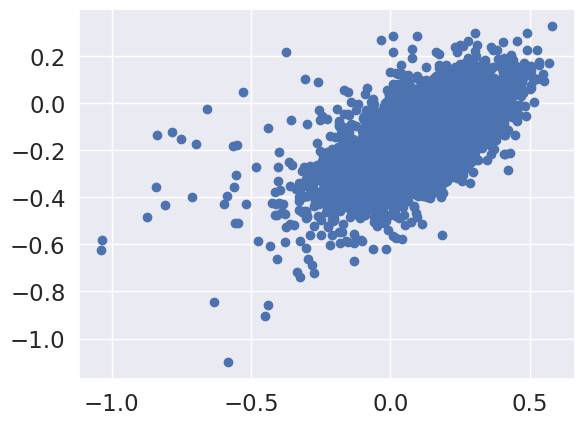

In [101]:
plt.scatter(model.A_[:, 0], model.A_[:, 1], cmap = 'hot')

Using svd

In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
from scipy.sparse.linalg import svds

k_values = [2,3,4,5,8,10]
rmse_scores = []

for k in k_values:
    # Decompose the matrix with k latent factors
    U, sigma, Vt = svds(train_matrix.values, k=k)
    sigma = np.diag(sigma)

    # Reconstruct the matrix
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)

    # Evaluate on validation set
    val_actuals = val_matrix.values.flatten()
    val_predictions = np.dot(np.dot(U, sigma), Vt).flatten()

    min_length = min(len(val_actuals), len(val_predictions))

    val_actuals = val_actuals[:min_length]
    val_predictions = val_predictions[:min_length]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
    rmse_scores.append(rmse)
    print(f"k={k}, RMSE={rmse}")


k=2, RMSE=0.49186215513216885
k=3, RMSE=0.5016023415517766
k=4, RMSE=0.5098652139828763
k=5, RMSE=0.5158886813137445
k=8, RMSE=0.5292108718831611
k=10, RMSE=0.5353014531192657


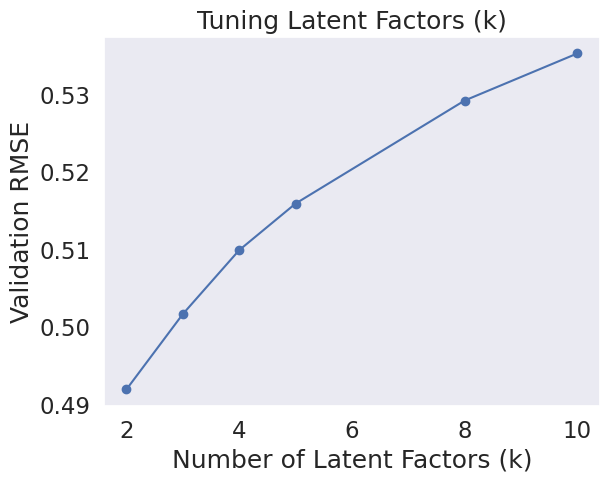

In [85]:
import matplotlib.pyplot as plt

plt.plot(k_values, rmse_scores, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Validation RMSE')
plt.title('Tuning Latent Factors (k)')
plt.grid()
plt.show()


#### Model Evaluation

In [86]:
k=4
U, sigma, Vt = svds(train_matrix.values, k=k)
sigma = np.diag(sigma)

# Reconstruct the matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Evaluate on validation set
val_actuals = val_matrix.values.flatten()
val_predictions = np.dot(np.dot(U, sigma), Vt).flatten()

min_length = min(len(val_actuals), len(val_predictions))

val_actuals = val_actuals[:min_length]
val_predictions = val_predictions[:min_length]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))
rmse_scores.append(rmse)
print(f"k={k}, RMSE={rmse}")

mape = np.mean(np.abs((val_actuals - val_predictions) / (val_actuals + 1e-7))) * 100
print(f"MAPE: {mape}")

k=4, RMSE=0.5098652139828763
MAPE: 146239429.03792518


### Visualization of Embeddings

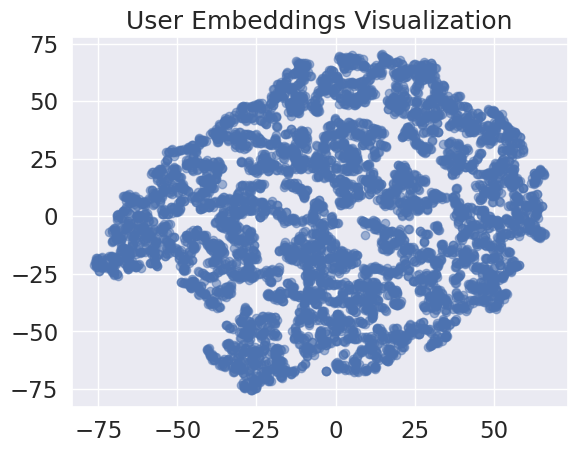

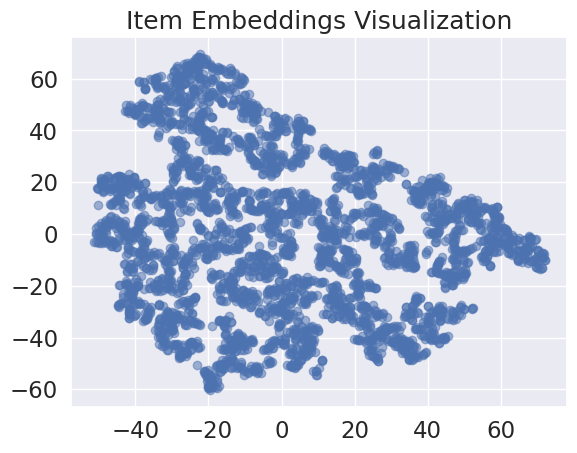

In [103]:
from sklearn.manifold import TSNE

# User Embeddings
user_embeddings = TSNE(n_components=2).fit_transform(U)
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1], alpha=0.5)
plt.title('User Embeddings Visualization')
plt.show()

# Item Embeddings
item_embeddings = TSNE(n_components=2).fit_transform(Vt.T)
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1], alpha=0.5)
plt.title('Item Embeddings Visualization')
plt.show()

In [104]:
def recommend_movies(user_id, predicted_df, top_n=10):
    user_ratings = predicted_df.loc[user_id]
    top_movies = user_ratings.sort_values(ascending=False).head(top_n)
    return top_movies.index.tolist()

num_users = len(val_matrix.index)
num_movies = len(val_matrix.columns)

# Reshape val_predictions to match the shape of val_matrix
val_predictions_reshaped = np.dot(np.dot(U, sigma), Vt)  # Reconstruct the predicted ratings matrix
val_predictions_reshaped = val_predictions_reshaped[:num_users, :num_movies]  # Trim to the correct shape if necessary

predicted_df = pd.DataFrame(val_predictions_reshaped, index=val_matrix.index, columns=val_matrix.columns)

recommendations = recommend_movies(user_id=1, predicted_df=predicted_df)
print("Recommended Movies for User 1:", recommendations)

Recommended Movies for User 1: ['2948', '82', '3297', '802', '710', '3052', '1280', '2463', '2849', '121']


### SVD with 2-embeddings and Visualization

In [102]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=14c856306ce0d24b95cf759500f6029d0989a810fa41a6a47a350aed28e5178b
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [105]:
from surprise.model_selection import train_test_split , cross_validate , KFold
from surprise import Reader, SVD , Dataset , KNNWithMeans , accuracy

In [106]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  object
 1   MovieID     1000209 non-null  object
 2   Rating      1000209 non-null  object
 3   Watch_Hour  1000209 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [107]:
ratings_df.UserID = ratings_df.UserID.astype(int)
ratings_df.MovieID = ratings_df.MovieID.astype(int)
ratings_df.Rating = ratings_df.Rating.astype(int)

In [108]:
reader = Reader(rating_scale=(1 , 5))

data = Dataset.load_from_df(ratings_df[['UserID','MovieID','Rating']], reader)

In [109]:
svd = SVD(n_factors=2)
cross_validate(svd,data, measures=['rmse','mae'], cv = 5 , return_train_measures=True,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8930  0.8927  0.8964  0.8889  0.8945  0.8931  0.0025  
MAE (testset)     0.7051  0.7054  0.7085  0.7008  0.7067  0.7053  0.0025  
RMSE (trainset)   0.8732  0.8736  0.8806  0.8689  0.8732  0.8739  0.0038  
MAE (trainset)    0.6900  0.6907  0.6963  0.6863  0.6902  0.6907  0.0032  
Fit time          8.01    14.39   10.42   13.35   9.30    11.09   2.42    
Test time         3.05    3.51    2.71    2.49    1.34    2.62    0.72    


{'test_rmse': array([0.8929834 , 0.89267381, 0.89639948, 0.88885355, 0.89453268]),
 'train_rmse': array([0.87320459, 0.8735566 , 0.88056949, 0.86887928, 0.87324679]),
 'test_mae': array([0.70506512, 0.70540907, 0.70846592, 0.70079892, 0.70671907]),
 'train_mae': array([0.68996619, 0.69074708, 0.69630576, 0.68630754, 0.69016041]),
 'fit_time': (8.009260416030884,
  14.390578031539917,
  10.421465635299683,
  13.352989435195923,
  9.296149492263794),
 'test_time': (3.0455281734466553,
  3.507093667984009,
  2.7058186531066895,
  2.4908697605133057,
  1.3416166305541992)}

In [110]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [111]:
# Get movie recommendations for user 1 with highest estimated ratings for original ratings = 5
items = movies_df['Title'].unique()
test = [[1,movie,5] for movie in items]
predictions = svd.test(test)
pred = pd.DataFrame(predictions)

In [112]:
pred.sort_values('est', ascending=False).head()

,uid,iid,r_ui,est,details
0,1,Toy Story,5,3.76772,{'was_impossible': False}
2560,1,It Came from Hollywood,5,3.76772,{'was_impossible': False}
2548,1,House of Frankenstein,5,3.76772,{'was_impossible': False}
2549,1,Frankenstein,5,3.76772,{'was_impossible': False}
2550,1,Son of Frankenstein,5,3.76772,{'was_impossible': False}


In [113]:
print('SVD - RMSE:', accuracy.rmse(predictions, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions, verbose=False))

SVD - RMSE: 1.2322796645150749
SVD - MAE: 1.2322796645150744


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3706 samples in 0.003s...
[t-SNE] Computed neighbors for 3706 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3706
[t-SNE] Computed conditional probabilities for sample 2000 / 3706
[t-SNE] Computed conditional probabilities for sample 3000 / 3706
[t-SNE] Computed conditional probabilities for sample 3706 / 3706
[t-SNE] Mean sigma: 0.034506
[t-SNE] Computed conditional probabilities in 0.334s
[t-SNE] Iteration 50: error = 65.9677658, gradient norm = 0.0074210 (50 iterations in 2.660s)
[t-SNE] Iteration 100: error = 63.2257957, gradient norm = 0.0032294 (50 iterations in 2.015s)
[t-SNE] Iteration 150: error = 62.7930336, gradient norm = 0.0012285 (50 iterations in 2.106s)
[t-SNE] Iteration 200: error = 62.6821709, gradient norm = 0.0005932 (50 iterations in 2.104s)
[t-SNE] Iteration 250: error = 62.6491585, gradient norm = 0.0002974 (50 iterations in 2.096s)
[t-SNE] KL divergence after 250 iterat

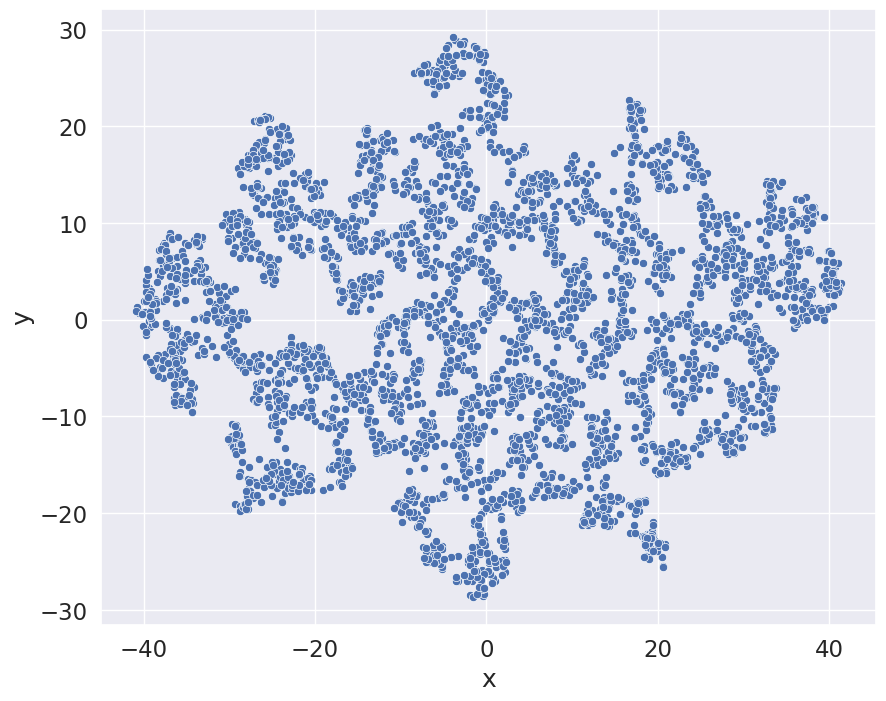

In [114]:
tsne = TSNE(n_components=2, n_iter=500, verbose=3, random_state=1, perplexity=50)
movies_embedding = tsne.fit_transform(svd.qi)
projection = pd.DataFrame(columns=['x', 'y'], data=movies_embedding)

plt.figure(figsize=(10,8))
sns.scatterplot(data=projection, x='x',y='y')
plt.show()

## **Questionnare**

**1.Users of which age group have watched and rated the most number of movies?**

Age group 25-35

In [115]:
d.groupby("Age").size().sort_values(ascending=False)

,0
Age,
25-34,394105
35-44,198084
18-24,183047
45-49,83161
50-55,72071
56+,38544
Under 18,27132


**2.Users belonging to which profession have watched and rated the most movies?**

College Graduate Students and Other Occupation

In [116]:
d.groupby("Occupation").size().sort_values(ascending=False)

,0
Occupation,
college/grad student,130626
other,130001
executive/managerial,105013
academic/educator,84936
technician/engineer,72534
writer,60098
programmer,56931
artist,49823
sales/marketing,48952


**3.Most of the users in our dataset who’ve rated the movies are Male. (T/F)**

True

**4.Most of the movies present in our dataset were released in which decade?**

a.70s **b. 90s** c. 50s d.80s

In [117]:
movies_per_decade

,MovieID,% of movies per decade
Decade,,
20s,23,0.624661
30s,71,1.928300
40s,120,3.259098
50s,164,4.454101
60s,184,4.997284
70s,237,6.436719
80s,586,15.915263
90s,2294,62.303096


**5.The movie with maximum no. of ratings is**

American Beauty

In [118]:
d.groupby("Title").size().sort_values(ascending=False)

,0
Title,
American Beauty,3428
Star Wars: Episode IV - A New Hope,2991
Star Wars: Episode V - The Empire Strikes Back,2990
Star Wars: Episode VI - Return of the Jedi,2883
Jurassic Park,2672
...,...
Bittersweet Motel,1
"Lay of the Land, The",1
"Silence of the Palace, The",1


**6.Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**



In [119]:
recommend("Liar Liar ")

,Correlation
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222


**7.On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.**

Memory based and Model based.

**8.Pearson Correlation ranges between `-1 `to `1` whereas, Cosine Similarity belongs to the interval between `-1` to `1`.**




**9.Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**

  * RMSE=0.5091539624515389
  * MAPE: 146044790.68332076

**10.Give the sparse ‘row’ matrix representation for the following dense matrix -**

[[1 0]
[3 7]]

In [120]:
from scipy.sparse import csr_matrix

d_m = np.array([[1,0],[3,7]])
s_m = csr_matrix(d_m)
print(s_m.data)
print(s_m.indices)
print(s_m.indptr)

[1 3 7]
[0 0 1]
[0 1 3]


## **Insights**
* Pearson correlation works well
* Cosine similarity also works good for item-item and user-user recommendation
* Males are top contributors while watching and rating the movies
* College/grad students are superusers of movie watching platform
* Age group 25-35 are the top users of the movie watching platform
* Comedy and Drama genres have the highest number of movies
* Maximum number of movies are released in the 90s with 1999 and 1997 being the top contributor
* Maximum number of movies watched or rated during the hour 3 and 21
* Clusters with ratings 3 and 4 are highly densed



##**Recommendations**
* Pearson correlation and item similarity matrix based on cosine similarity works well. So business can use these models
* To improve the accuracy of recommendation business can try to provide more metadata of movies and users
* Business can think of adding more contents for different age groups other than age group 25-35
* A good chunk of users are academic and educators, business can make sure to have enough contents for them.
* Female users are less than half of the male users. Business can think of implementing some offers to female users to increase the registration on the platform